# Image Classification with Transfer Learning

This notebook implements an image classification model using **PyTorch** and **transfer learning with a pretrained VGG16 network**.

The goal of the project is to classify images of flowers into **102 categories** using a labeled image dataset. The trained model can be used to predict the class of new images and demonstrates how deep learning models can be integrated into real-world applications.

<img src="assets/Flowers.png" width="500px">

## Project Overview
- Load and preprocess the image dataset
- Train an image classifier using transfer learning
- Evaluate model performance on validation and test sets
- Use the trained model to predict image classes

The approach used here can be adapted to other image classification tasks by replacing the dataset and retraining the model.


In [2]:
# Imports here
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader
from collections import OrderedDict

## Data Loading and Preprocessing

The flower image dataset is loaded using `torchvision.datasets.ImageFolder` and is split into training, validation, and test sets.

To improve model generalization, the training data undergoes several augmentation techniques including random rotations, resized crops, and horizontal flipping. All images are resized to **224×224 pixels**, which is required for the VGG16 architecture.

The validation and test datasets are only resized and center-cropped to ensure consistent evaluation without data augmentation.

All images are normalized using the same mean and standard deviation values used during VGG16’s pretraining on ImageNet:
- Mean: `[0.485, 0.456, 0.406]`
- Standard deviation: `[0.229, 0.224, 0.225]`


In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# Define image transformations for training, validation, and testing
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])]),
}
        

image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Create DataLoader objects for efficient batch processing
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=64, shuffle=True,
                        num_workers=4, pin_memory=True),
    
    'valid': DataLoader(image_datasets['valid'], batch_size=64,
                        num_workers=4, pin_memory=True),
    
    'test': DataLoader(image_datasets['test'], batch_size=64,
                       num_workers=4, pin_memory=True)
}

## Label Mapping

A JSON file is used to map numeric class labels to their corresponding flower names. This mapping allows model predictions to be translated into human-readable class labels during inference.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

## Model Architecture and Training

A pretrained **VGG16** model is used as the feature extractor. The convolutional layers are frozen to preserve learned features from ImageNet, and a custom fully connected classifier is attached to perform classification on the flower dataset.

The classifier consists of multiple linear layers with ReLU activations and dropout for regularization. Only the classifier layers are trained, while the feature extraction layers remain frozen.

The model is trained using the **Adam optimizer** and **cross-entropy loss**, and performance is monitored using validation loss and accuracy after each epoch.


In [6]:
import torch
torch.backends.cudnn.benchmark = True


In [7]:
# model architecture of VGG16
model = models.vgg16(pretrained=True)
model.classifier

C:\Users\afmal\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\afmal\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [8]:
# Freeze feature extractor parameters
for param in model.features.parameters():
    param.requires_grad = False

num_in_features = 25088
num_classes = 102

#modifying classifier
classifier = nn.Sequential(
    nn.Linear(num_in_features, 4096, bias=True),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, num_classes),
    
)
model.classifier = classifier
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=1024, out_features=102, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the classifier
epochs = 10

valid_losses, train_losses = [], []

for e in range(epochs):
    
    running_loss = 0
    model.train()
    
    for images, labels in dataloaders['train']:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward() 
        optimizer.step()

        running_loss += loss.item()
        
    else:
        
        valid_loss = 0
        accuracy = 0
        model.eval()
        with torch.no_grad():
            
            for images, labels in dataloaders['valid']:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                valid_loss += criterion(output, labels).item()
                
                ps = torch.softmax(output, dim=1)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
            model.train()
                
            train_losses.append(running_loss/len(dataloaders['train']))
            valid_losses.append(valid_loss/len(dataloaders['valid']))
            
            print(f"Epoch {e+1}/{epochs}.. "
              f"Train loss: {running_loss/len(dataloaders['train']):.3f}.. "
              f"Valid loss: {valid_loss/len(dataloaders['valid']):.3f}.. "
              f"Accuracy: {accuracy/len(dataloaders['valid']):.3f}")

Epoch 1/10.. Train loss: 3.031.. Valid loss: 1.188.. Accuracy: 0.662
Epoch 2/10.. Train loss: 1.716.. Valid loss: 0.894.. Accuracy: 0.751
Epoch 3/10.. Train loss: 1.466.. Valid loss: 0.714.. Accuracy: 0.812
Epoch 4/10.. Train loss: 1.325.. Valid loss: 0.576.. Accuracy: 0.849
Epoch 5/10.. Train loss: 1.252.. Valid loss: 0.514.. Accuracy: 0.862
Epoch 6/10.. Train loss: 1.183.. Valid loss: 0.615.. Accuracy: 0.842
Epoch 7/10.. Train loss: 1.193.. Valid loss: 0.552.. Accuracy: 0.858
Epoch 8/10.. Train loss: 1.213.. Valid loss: 0.526.. Accuracy: 0.839
Epoch 9/10.. Train loss: 1.130.. Valid loss: 0.507.. Accuracy: 0.874
Epoch 10/10.. Train loss: 1.148.. Valid loss: 0.534.. Accuracy: 0.872


## Model Evaluation on Test Data

After training, the model is evaluated on the test dataset, which contains images the network has never seen before. This provides an unbiased estimate of the model’s real-world performance.


In [10]:
# TODO: Do validation on the test set
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad(): 
    for images, labels in dataloaders['test']:
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        test_loss += criterion(output, labels).item()
                
        ps = torch.softmax(output, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test loss: {test_loss/len(dataloaders['test']):.3f}\n"
      f"Accuracy: {accuracy/len(dataloaders['test']):.3f}")

Test loss: 0.597
Accuracy: 0.844


## Saving the Trained Model

The trained model is saved as a checkpoint to allow reuse without retraining. The checkpoint includes the model architecture, classifier, learned parameters, class-to-index mapping, optimizer state, and number of training epochs.


In [11]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {
    'arch': 'vgg16',
    'classifier': model.classifier,
    'class_to_idx': model.class_to_idx,
    'state_dict': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'epochs': epochs
}

torch.save(checkpoint, 'checkpoint.pth')

## Loading a Saved Model

A helper function is implemented to load a saved checkpoint and reconstruct the trained model. This enables inference or continued training without repeating the full training process.


In [12]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath, map_location='cpu', weights_only=False)
        
    arch = checkpoint['arch']
    if arch == 'vgg16':
        model = models.vgg16(pretrained=True)
    else:
        raise ValueError(f"Unsupported architecture: {arch}")
        
    for param in model.features.parameters():
        param.requires_grad = False
        
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    model.epochs = checkpoint['epochs']
    
    return model

In [13]:
loaded_model = load_checkpoint("checkpoint.pth")
print(loaded_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=1024, out_features=102, bias=True)
)


# Image Inference

The trained model can be used to predict the most likely flower classes for a given input image. The prediction function returns the top-K class probabilities along with their corresponding class labels.


## Image Preprocessing

Input images are preprocessed to match the format expected by the trained network. Images are resized, center-cropped, normalized using ImageNet statistics, and converted into PyTorch tensors with the correct channel ordering.


In [14]:
from PIL import Image
import numpy as np
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    img = Image.open(image)
    img.thumbnail((256, 256))
    width, height = img.size
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = (width + 224) / 2
    bottom = (height + 224) / 2
    img=img.crop((int(left), int(top), int(right), int(bottom)))
    
    np_image = np.array(img) / 255.0
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    np_image = np_image.transpose((2, 0, 1))
    
    return torch.from_numpy(np_image)

In [17]:
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

The prediction function computes class probabilities using a softmax layer and returns the top-K most probable flower classes. Class indices are converted back to their original labels using the stored class-to-index mapping.


In [18]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    image = process_image(image_path)
    image = image.float()
    image = image.unsqueeze(0)
    
    device = next(model.parameters()).device
    image = image.to(device)
    model = model.to(device)
    
    with torch.no_grad():
        output = model(image)
        prob = torch.softmax(output, dim = 1)
        top_p, top_class_idx = prob.topk(topk, dim=1)
        
        top_p = top_p.squeeze().tolist()
        top_class_idx = top_class_idx.squeeze().tolist()
        
        idx_to_class = {j: i for i, j in model.class_to_idx.items()}
        top_classes = [idx_to_class[i] for i in top_class_idx]
        
        return top_p, top_classes

## Sanity Check and Visualization

To verify prediction quality, the input image is displayed alongside a horizontal bar chart showing the predicted probabilities for the top five classes. This provides an intuitive way to assess whether the model’s predictions are reasonable.


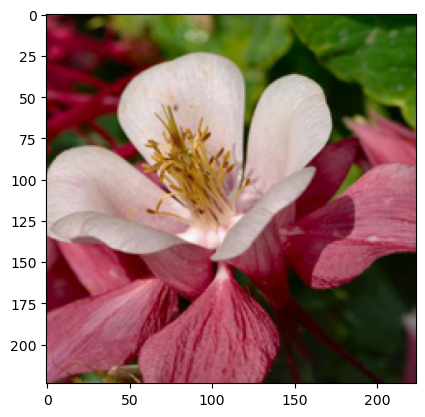

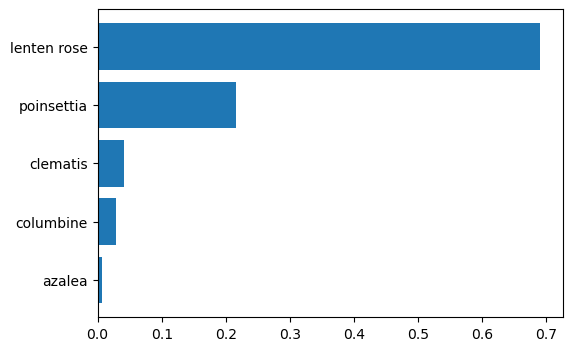

In [19]:
# TODO: Display an image along with the top 5 classes
image_path = "flowers/test/84/image_02615.jpg"

probs, classes = predict(image_path, loaded_model)

flower_names = [cat_to_name[c] for c in classes]
imshow(process_image(image_path), title=flower_names[0])

plt.figure(figsize=(6,4))
y = np.arange(len(flower_names))
plt.barh(y, probs)
plt.yticks(y, flower_names)
plt.gca().invert_yaxis()
plt.show()